# Regression Example
Latent Dimensionality Reduction applied to the [Boston house prices dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston).

Useful because of the ability to backtrack from a model, and identify what metrics are significant indicators of issues.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import OneClassSVM
from sklearn import svm
from sklearn.neighbors import KernelDensity

from ldr import LDR

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

In [3]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
targets = pd.Series(data.target)
print("Shape:", df.shape)
df.head()

Shape: (506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


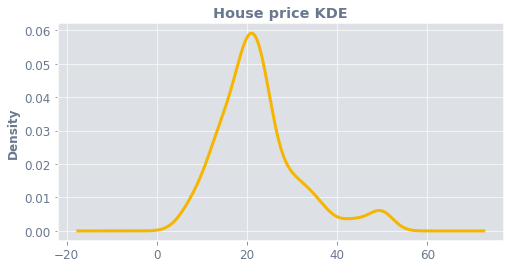

In [4]:
targets.plot.kde(figsize=(8, 4), title="House price KDE")

Scale the data.

In [5]:
ldr = LDR(df, targets, "reg")

In [6]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    ldr.scaled, ldr.targets, test_size=0.3, random_state=42)

Define features to visualize. Features are:
```text
CRIM: Per capita crime rate by town
ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
INDUS: Proportion of non-retail business acres per town
CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX: Nitric oxide concentration (parts per 10 million)
RM: Average number of rooms per dwelling
AGE: Proportion of owner-occupied units built prior to 1940
DIS: Weighted distances to five Boston employment centers
RAD: Index of accessibility to radial highways
TAX: Full-value property tax rate per $10,000
PTRATIO: Pupil-teacher ratio by town
B: 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town
LSTAT: Percentage of lower status of the population
MEDV: Median value of owner-occupied homes in $1000s
```

In [7]:
features = ["AGE", "RM", "CRIM"]

## Regression Training and Analysis

In [8]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
5,0.000264,0.0,0.063050,0.0,0.150206,0.549722,0.574665,0.448545,0.086957,0.066794,0.648936,0.992990,0.096026
116,0.001408,0.0,0.350073,0.0,0.333333,0.501054,0.716787,0.145541,0.217391,0.467557,0.553191,0.990922,0.284492
45,0.001856,0.0,0.236437,0.0,0.129630,0.406400,0.318229,0.361084,0.086957,0.087786,0.563830,1.000000,0.233996
16,0.011775,0.0,0.281525,0.0,0.314815,0.454876,0.271885,0.306359,0.130435,0.229008,0.893617,0.974658,0.133830
468,0.174996,0.0,0.646628,0.0,0.401235,0.453152,0.701339,0.161755,1.000000,0.914122,0.808511,0.928993,0.452539


### Random Forests

In [9]:
rf_clf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_clf = svm.SVR(gamma="scale", epsilon=0.02)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, preds))

Mean Squared Error: 0.0046098265789473675


In [10]:
def rf_clf_func(df):
    return np.array(rf_clf.predict(df))

In [11]:
tst = rf_clf_func(X_train[:30])
print(tst[:30])

[0.49117778 0.3564     0.32082222 0.3802     0.29117778 0.43135556
 0.64335556 0.03593333 0.48375556 0.31553333 0.35835556 0.40133333
 0.37551111 0.37948889 0.93573333 0.22111111 0.27946667 0.38946667
 0.3396     0.33184444 0.36557778 0.7254     0.37931111 0.33413333
 0.31993333 0.52846667 0.67617778 0.43222222 0.16708889 0.17268889]


### One Class SVM
Used for outlier detection/estimating a learning frontier. The SVM is set to use 10% of points estimated as outliers to set the learning frontier.

In [12]:
oc_clf = OneClassSVM(gamma='auto', nu=0.1).fit(X_train)

In [13]:
def oc_clf_func(df):
    pred = oc_clf.predict(df)
    return [(i + 1) / 2 for i in pred]

In [14]:
tst = oc_clf_func(X_train)
pd.Series(tst).value_counts()

1.0    318
0.0     36
dtype: int64

## Random Forest Classifier and Outlier Detection Superposition

In [15]:
def oc_rf_clf_func(df):
    oc_pred = oc_clf_func(df)
    rf_pred = rf_clf_func(df)
    return [(rf_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [16]:
tst = oc_rf_clf_func(X_train[:30])
print(tst[:30])

[0.4911777777777771, 0.35639999999999966, 0.3208222222222221, 0.38019999999999965, 0.2911777777777774, 0.43135555555555527, 0.6433555555555549, 0.5, 0.4837555555555557, 0.3155333333333338, 0.35835555555555587, 0.401333333333333, 0.3755111111111112, 0.37948888888888843, 0.9357333333333329, 0.22111111111111137, 0.2794666666666669, 0.38946666666666635, 0.33959999999999974, 0.331844444444445, 0.3655777777777775, 0.7253999999999999, 0.37931111111111077, 0.3341333333333334, 0.3199333333333337, 0.5284666666666662, 0.6761777777777782, 0.43222222222222273, 0.5, 0.5]


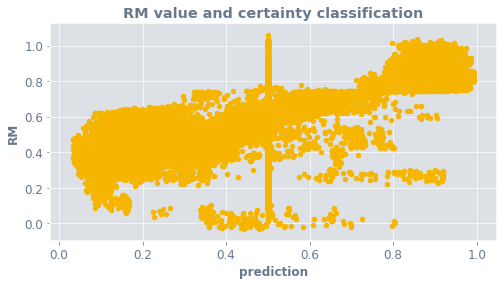

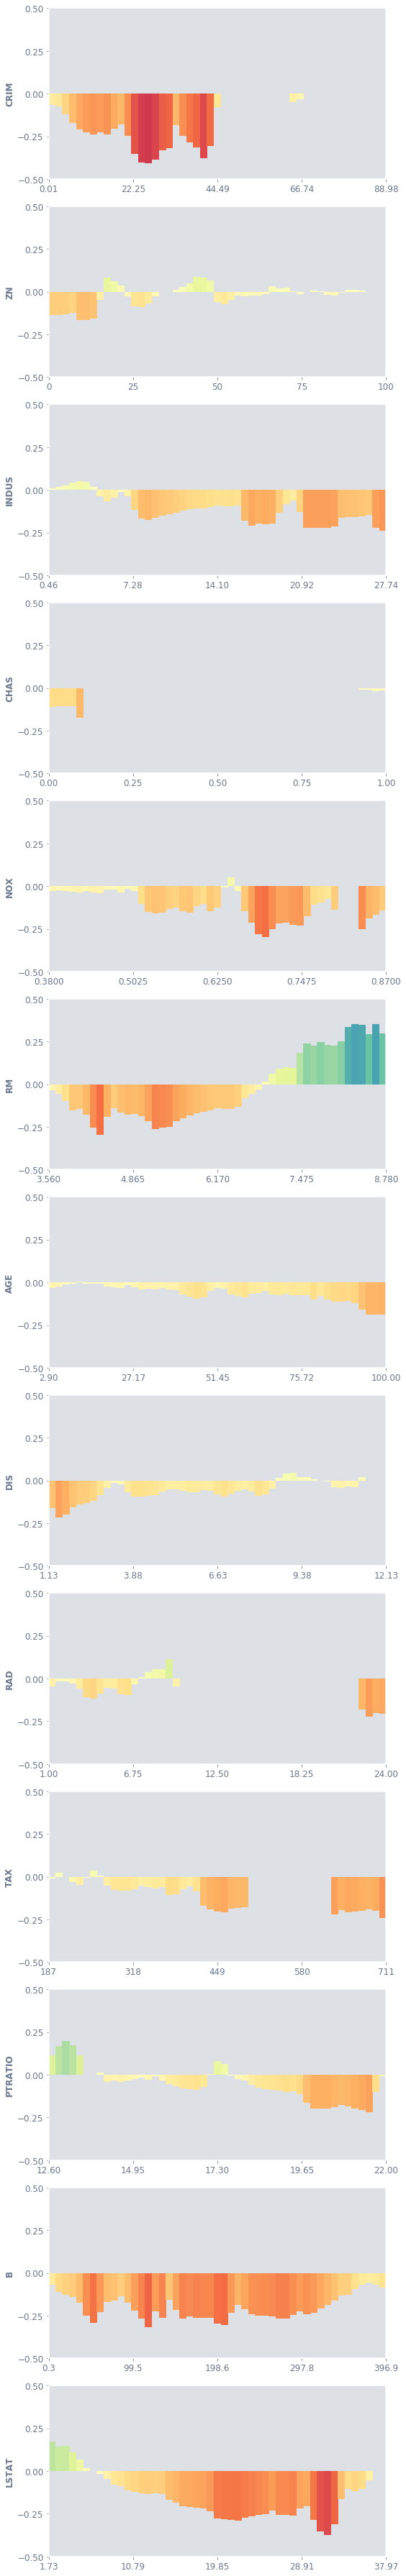

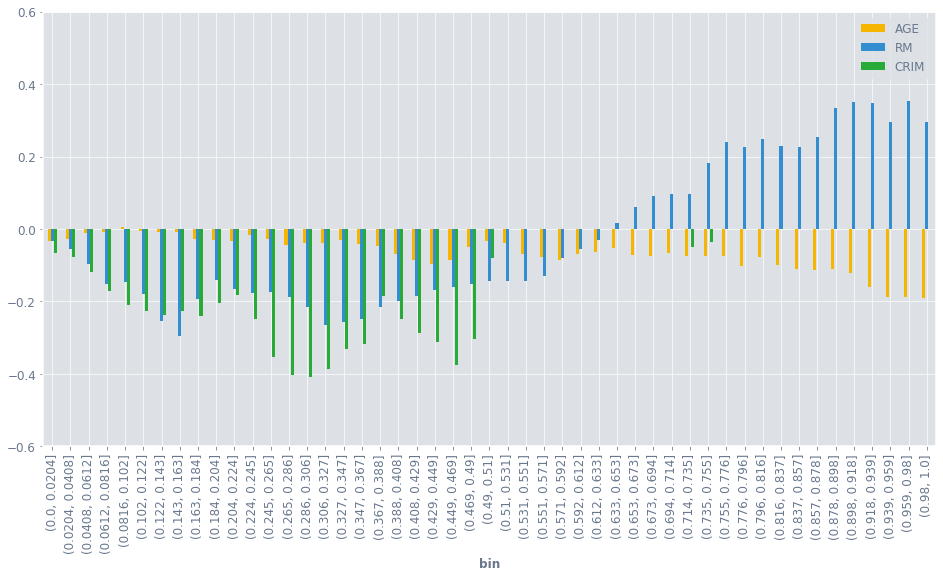

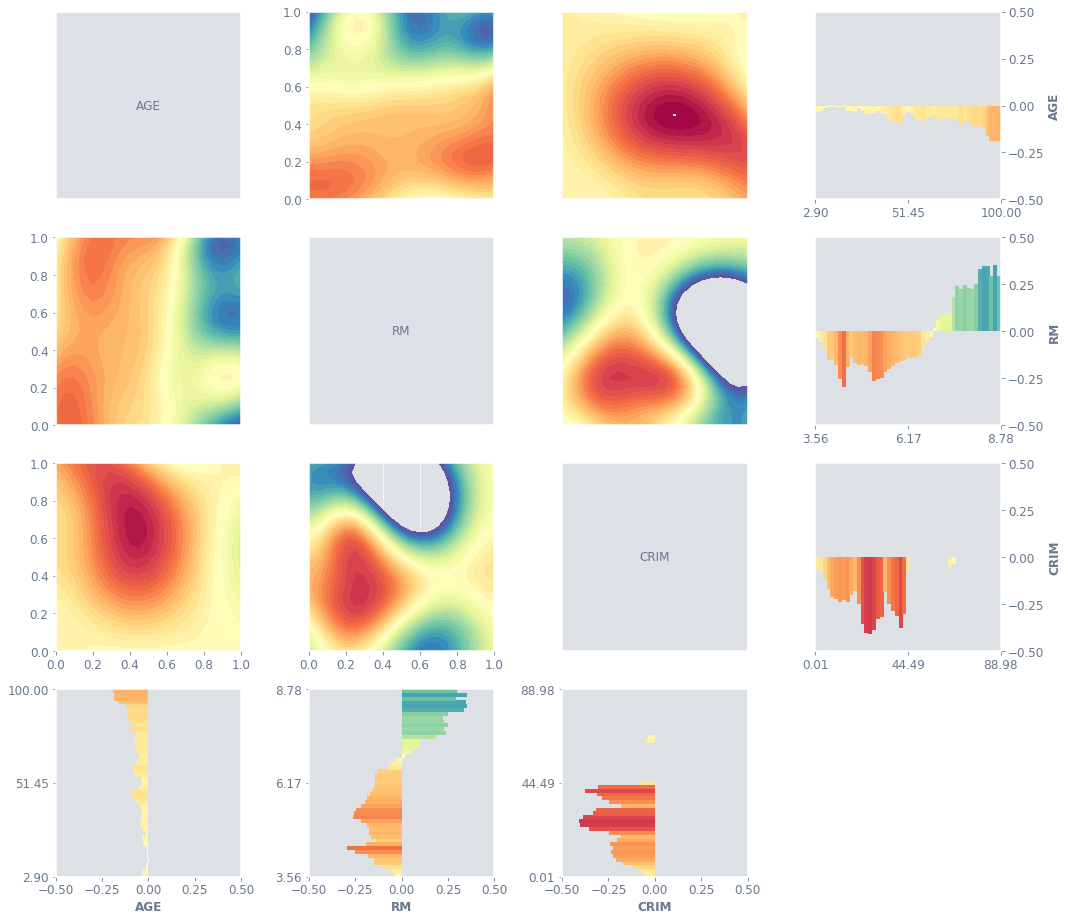

In [17]:
ldr.density_estimate(oc_rf_clf_func, n=50000)
ldr.density_scatter(features[1])
ldr.vis_1d_separate()
ldr.select_1d_bins(features)
ldr.vis_1d()
ldr.vis_2d()

* An increasing crime rate tends to correlated with houses being worth less. Above the mediun level of crime however, the model becomes unsure.
* Houses with fewer rooms but a lower level of crime are worth similar to those with a higher level of crime but more rooms. There are however not many houses in areas with high amounts of crime and lots of rooms.
* The older the house, the less it tends to be worth.
* For the msot part, age of the house and the crime rate are independent with relation to the price.
